In [31]:
#Code from Fabio to import index data including applying comp matrix - JT mods added
import os
import sys
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import fcsparser

Text(0.5, 0.98, 'CD34 plates')

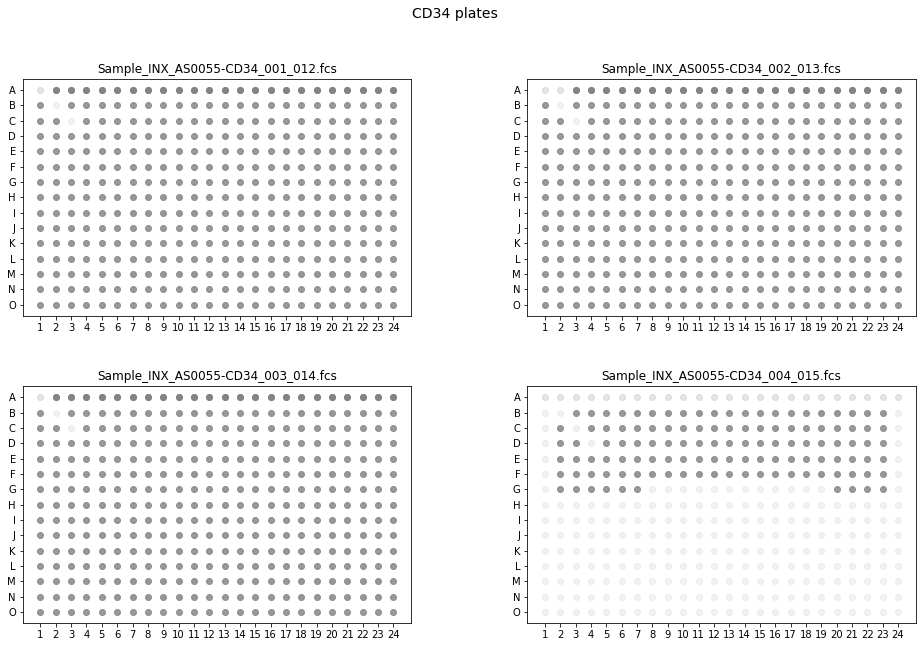

In [32]:
#Plate QC - check that cells are in the expected locations

directory = '../Data/RN_BM/Indexed/'


#Set up the plots
fig, ax = plt.subplots(2,2, figsize = (16,10))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

count = -1

xwell = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
ywell = [0,1,2,3,4,5,6,7,8,9,0,11,12,13,14,15]
allwells = []

for a in ywell: #this creates a list of all possible locations
    for b in xwell:
        allwells.append(str(a) + ','+ str(b))
        
#Read in files and plot the data for each

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    
    count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)

    i = 1
    key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = [] #Sort locations from the metadata, numerical row then column starting at 0
    while key in meta:
        sort_locs.append(meta[key])
        i += 1
        key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = ''.join(sort_locs).split(';')

    for well in allwells:
        if well in sort_locs:  #if the well is in the list of wells with a sorted cell the colour will be darker
            alpha = 0.8
        else:
            alpha = 0.1        #plot empty wells in a lighter shade
            
        y, x = well.split(',')
        ax[count].scatter(x, y, alpha=alpha, color='gray')      
    ax[count].set_title(plateid)
    ax[count].invert_yaxis()  #flip the axis so the plate order looks natural
    ax[count].set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24'])
    ax[count].set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'])

fig.suptitle('CD34 plates', fontsize=14)    
          
#plt.close()

In [33]:
#Now read data into df and apply compensation, then output combined df with all rw or comp values
directory = '../Data/RN_BM/Indexed/'

data_dict = {}
data_dict_comp = {}

plate_key = {'Sample_INX_AS0055-CD34_001_012.fcs': 'not_seq',
 'Sample_INX_AS0055-CD34_002_013.fcs': 'AS-197',
 'Sample_INX_AS0055-CD34_003_014.fcs': 'AS-198',
 'Sample_INX_AS0055-CD34_004_015.fcs': 'AS-201'}

#Set up comp plots
fig, ax = plt.subplots(2,2, figsize = (8,6))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

count = -1

#Read in files and metadata

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)

    i = 1
    key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = []
    while key in meta:
        sort_locs.append(meta[key])
        i += 1
        key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = ''.join(sort_locs).split(';')
    wells = []
    for loc in sort_locs:
        if loc == '':
            continue
        row_index, col = loc.split(',')
        col = str(int(col)+1)
        row = chr(65 + int(row_index)) #JT changed this to 65 from 64 - 65 is unicode for A, locations start at 0 (was 1 in test plate)
        well = row+col
        wells.append(well)   #Wells is a list of well locations with data derived from the index file
    
    # Get antibodies and rename with well names
    channel_idx = [int(x[2:-1]) for x in meta if x.startswith('$P') and x.endswith('S')]
    channeld = {meta['_channel_names_'][i-1]: meta[f'$P{i}S'] for i in channel_idx}

    data.index = pd.Index(wells, name='Sorted well') #Renames index with well name
    
    # Load compensation
    comp_fields = meta['SPILL'].split(',')
    n = int(comp_fields[0])
    channels = comp_fields[1: n+1]
    matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 
    # TODO: perhaps transpose the matrix?
    # matrix = matrix.T
    spill_matrix = pd.DataFrame(
        matrix,
        index=channels,
        columns=channels,
    )  #spill_matrix is the comp matrix
    
    #Plots compensation matrix
    # Reorder the dyes by wavelength
    wls = [int(x.split('/')[0][-3:]) for x in channels]
    idx = np.argsort(wls)
    spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

    ax[count] = sns.heatmap(spill_by_wls, ax=ax[count])
    ax[count].set_title(plateid)

    
    #Apply comp and replace column names with antibodies
    data_comp = data.copy()
    compensation = spill_matrix
    # TODO: Perhaps the inverse matrix?
    #compensation.values = numpy.linalg.inv(compensation.values)
    for channel in channels:
        data_comp[channel] *= compensation.loc[channel].values @ data_comp[channels].values.T #@ here is doing the matrix multiplication
    
    #Store df and compdf for this iteration as a unique variable
    data_comp.rename(columns = channeld, inplace = True)
    data.rename(columns = channeld, inplace = True)
    
    plate = plate_key.get(filename) #pull the plate name for this file and use to label output dictionaries
    data['Well'] = data.index.get_level_values(0)
    data_comp['Well'] = data_comp.index.get_level_values(0)
    data['Plate'] = plate #add new column with plate name
    data_comp['Plate'] = plate  #add new column with plate name
    data_dict_comp[plate] = data_comp #output df into a dictionary
    data_dict[plate] = data  #output df into a dictionary      
  
fig.tight_layout()  
plt.close() #comment out to view comp plots

#Combine all data or data_comp df into a single large df for gating
CD34_alldata = data_dict['not_seq'].append(data_dict['AS-197'], ignore_index=True).append(data_dict['AS-198'], ignore_index=True).append(data_dict['AS-201'], ignore_index=True)
CD34_alldata_comp = data_dict_comp['not_seq'].append(data_dict_comp['AS-197'], ignore_index=True).append(data_dict_comp['AS-198'], ignore_index=True).append(data_dict_comp['AS-201'], ignore_index=True)


In [34]:
#QC step Check number of cells in each df - why is there a cell missing in plate AS-197?
x = 0
for key, value in data_dict.items():
    print(f'Length of {key} is ', value.shape[0])
    x += value.shape[0]
    
test = data_dict['AS-197']
wells = test['Well'].to_list()

test2 = data_dict['AS-198']
wells2 = test2['Well'].to_list()

for a in wells2:
    if a in wells:
        continue

    else:
        print(f'Missing well is {a}') #All good, can see in plot there's no data here
        
#Check resulting df are the expected length (381 + 380 + 381 + 117 = 1259)
print(f'Expected dataframe length is {x}')
print('Length of raw dataframe is', CD34_alldata.shape[0])
print('Length of comp dataframe is', CD34_alldata_comp.shape[0])


Length of not_seq is  381
Length of AS-197 is  380
Length of AS-198 is  381
Length of AS-201 is  117
Missing well is A2
Expected dataframe length is 1259
Length of raw dataframe is 1259
Length of comp dataframe is 1259


In [35]:
#Still not happy with the compensation, TO DO - fix it

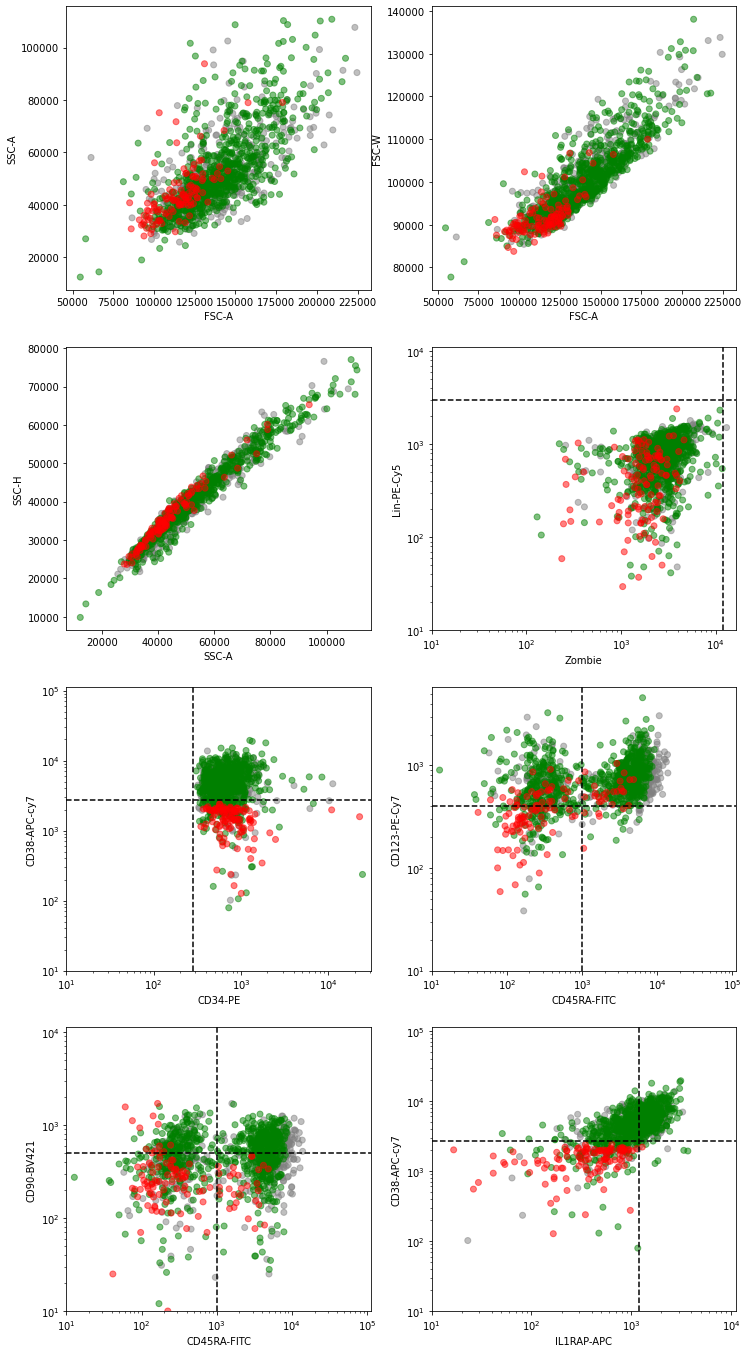

In [36]:
#Let's just get on with plotting

sourcedata = CD34_alldata.copy()  #Can swap to a different df here to look at compensated data

#Here's what's being plotted
plot_list = [
    ['FSC-A', 'SSC-A'],
    ['FSC-A', 'FSC-W'],
    ['SSC-A', 'SSC-H'],
    ['Zombie', 'Lin-PE-Cy5'], 
    ['CD34-PE', 'CD38-APC-cy7'],
    ['CD45RA-FITC', 'CD123-PE-Cy7'],
    ['CD45RA-FITC', 'CD90-BV421'],
    ['IL1RAP-APC', 'CD38-APC-cy7'] 
]

#Define colour palette here, and make a new column for it (c=  can only take a number or colour, not a categorical)
plates = sourcedata['Plate'].drop_duplicates().to_list()
cols = ['gray', 'green', 'green', 'red'] #can replace the colours used here
palette = dict(zip(plates, cols))

sourcedata['Colour'] = sourcedata['Plate'].replace(palette)

#Proposed gate locations
gate_loc = {
    'Lin-PE-Cy5': 3000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 2700 ,
    'CD45RA-FITC': 1000 ,
    'CD123-PE-Cy7': 400,
    'Zombie': 12000,
    'IL1RAP-APC': 1200,
    'CD90-BV421': 500,
}

#Which fluorophores are on a log scale
logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

fix, axs = plt.subplots(4,2, figsize = (12,24))
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

for ax,y in zip(axs, plot_list):
    x_label = y[0]
    y_label = y[1]
    ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.5, c = sourcedata['Colour'])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if x_label in logs:
        ax.set_xscale('log')
        ax.set_xlim(left = 10)
    if y_label in logs:
        ax.set_yscale('log')
        ax.set_ylim(bottom = 10)
    if x_label in gate_loc:
        ax.axvline(gate_loc[x_label], ls = '--', c = 'k')
    if y_label in gate_loc:
        ax.axhline(gate_loc[y_label], ls = '--', c = 'k')   
        
    ax.autoscale_view()  
    
fig.tight_layout()    

In [37]:
#Next, use gates chosen above to assign marker expressed = True to each fluorophore
CD34_alldata

,FSC-A,FSC-W,FSC-H,SSC-A,SSC-W,SSC-H,CD34-PE,Lin-PE-Cy5,CD123-PE-Cy7,CD90-BV421,Zombie,CD45RA-FITC,IL1RAP-APC,CD38-APC-cy7,Time,Well,Plate
0,121773.593750,93347.468750,85493.0,39123.031250,79198.335938,32374.0,1054.030029,132.980011,2945.180176,104.0,1438.0,175.740005,798.400024,8964.799805,1706.800049,A2,not_seq
1,117292.500000,97890.882812,78525.0,36411.238281,83777.937500,28483.0,477.420013,973.370056,377.140015,567.0,2296.0,3442.590088,716.799988,2116.000000,1967.300049,A3,not_seq
2,145303.203125,108424.414062,87827.0,102507.750000,97748.312500,68727.0,1338.520020,719.400024,410.930023,715.0,3012.0,5486.220215,1170.400024,3369.600098,2181.899902,A4,not_seq
3,126592.195312,96132.671875,86301.0,76951.500000,79570.421875,63379.0,493.770020,1073.650024,512.299988,415.0,3403.0,11810.250000,815.200012,1988.000000,2477.199951,A5,not_seq
4,126399.593750,93120.546875,88957.0,51885.929688,79909.671875,42553.0,1763.619995,1097.630005,364.059998,457.0,2430.0,731.669983,931.200012,2352.000000,2730.500000,A6,not_seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,102075.296875,89801.820312,74493.0,38112.960938,77931.140625,32051.0,997.350037,26.160000,95.920006,513.0,1526.0,138.330002,154.400009,116.000000,97019.601562,F23,AS-201
1255,131025.593750,106709.257812,80470.0,93823.414062,94214.437500,65264.0,10922.890625,1228.430054,312.830017,202.0,3578.0,799.530029,546.400024,1965.599976,97529.796875,G23,AS-201
1256,129627.898438,94275.890625,90111.0,49185.449219,81607.570312,39499.0,425.100006,51.230003,567.890015,266.0,2118.0,367.140015,5.600000,1989.599976,98223.398438,G22,AS-201
1257,106696.796875,92610.734375,75504.0,43357.320312,78676.078125,36116.0,567.890015,755.369995,308.470001,119.0,2448.0,1691.280029,812.000000,1908.800049,98734.703125,G21,AS-201
